# Training and Comparing Various Models

To run these files please specify the file path to the folder

In [ ]:
folder_path = '/content/drive/MyDrive/Colab Notebooks/381 Final Project/ML Final Project/'

In [ ]:
# Cell 1: Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import uniform, randint
from torch.utils.data import DataLoader, TensorDataset
import warnings
import time
warnings.filterwarnings('ignore')

In [ ]:
# Cell 2: Load and verify the data
print("Loading preprocessed dataset...")
try:
    # Load the CSV and verify it's a DataFrame
    clean_data_path = folder_path + '(4) FINAL_CLEAN_SPOTIFY_DATA.csv'
    df = pd.read_csv(clean_data_path)
    print(f"Dataset loaded with shape: {df.shape}")

    # Verify data types
    print("DataFrame info:")
    print(df.dtypes)

    # Display first few rows to confirm data loading correctly
    print("\nFirst 5 rows:")
    print(df.head())

except Exception as e:
    print(f"Error loading data: {e}")
    exit()  # Exit if data cannot be loaded

Loading preprocessed dataset...
Dataset loaded with shape: (121064, 25)
DataFrame info:
Unnamed: 0               int64
Country                  int64
Popularity             float64
Album/Single           float64
Artist_followers       float64
Explicit               float64
danceability           float64
energy                 float64
key                    float64
loudness               float64
mode                   float64
speechiness            float64
acoustics              float64
instrumentalness       float64
liveliness             float64
valence                float64
tempo                  float64
duration_ms            float64
time_signature         float64
Genre                  float64
Days_since_release     float64
Released_after_2017    float64
senti_score            float64
Sentiment_Range        float64
dominant_topic         float64
dtype: object

First 5 rows:
   Unnamed: 0  Country  Popularity  Album/Single  Artist_followers  Explicit  \
0           0        1     1

Using 25 numeric columns for correlation matrix
Correlation matrix shape: (25, 25)


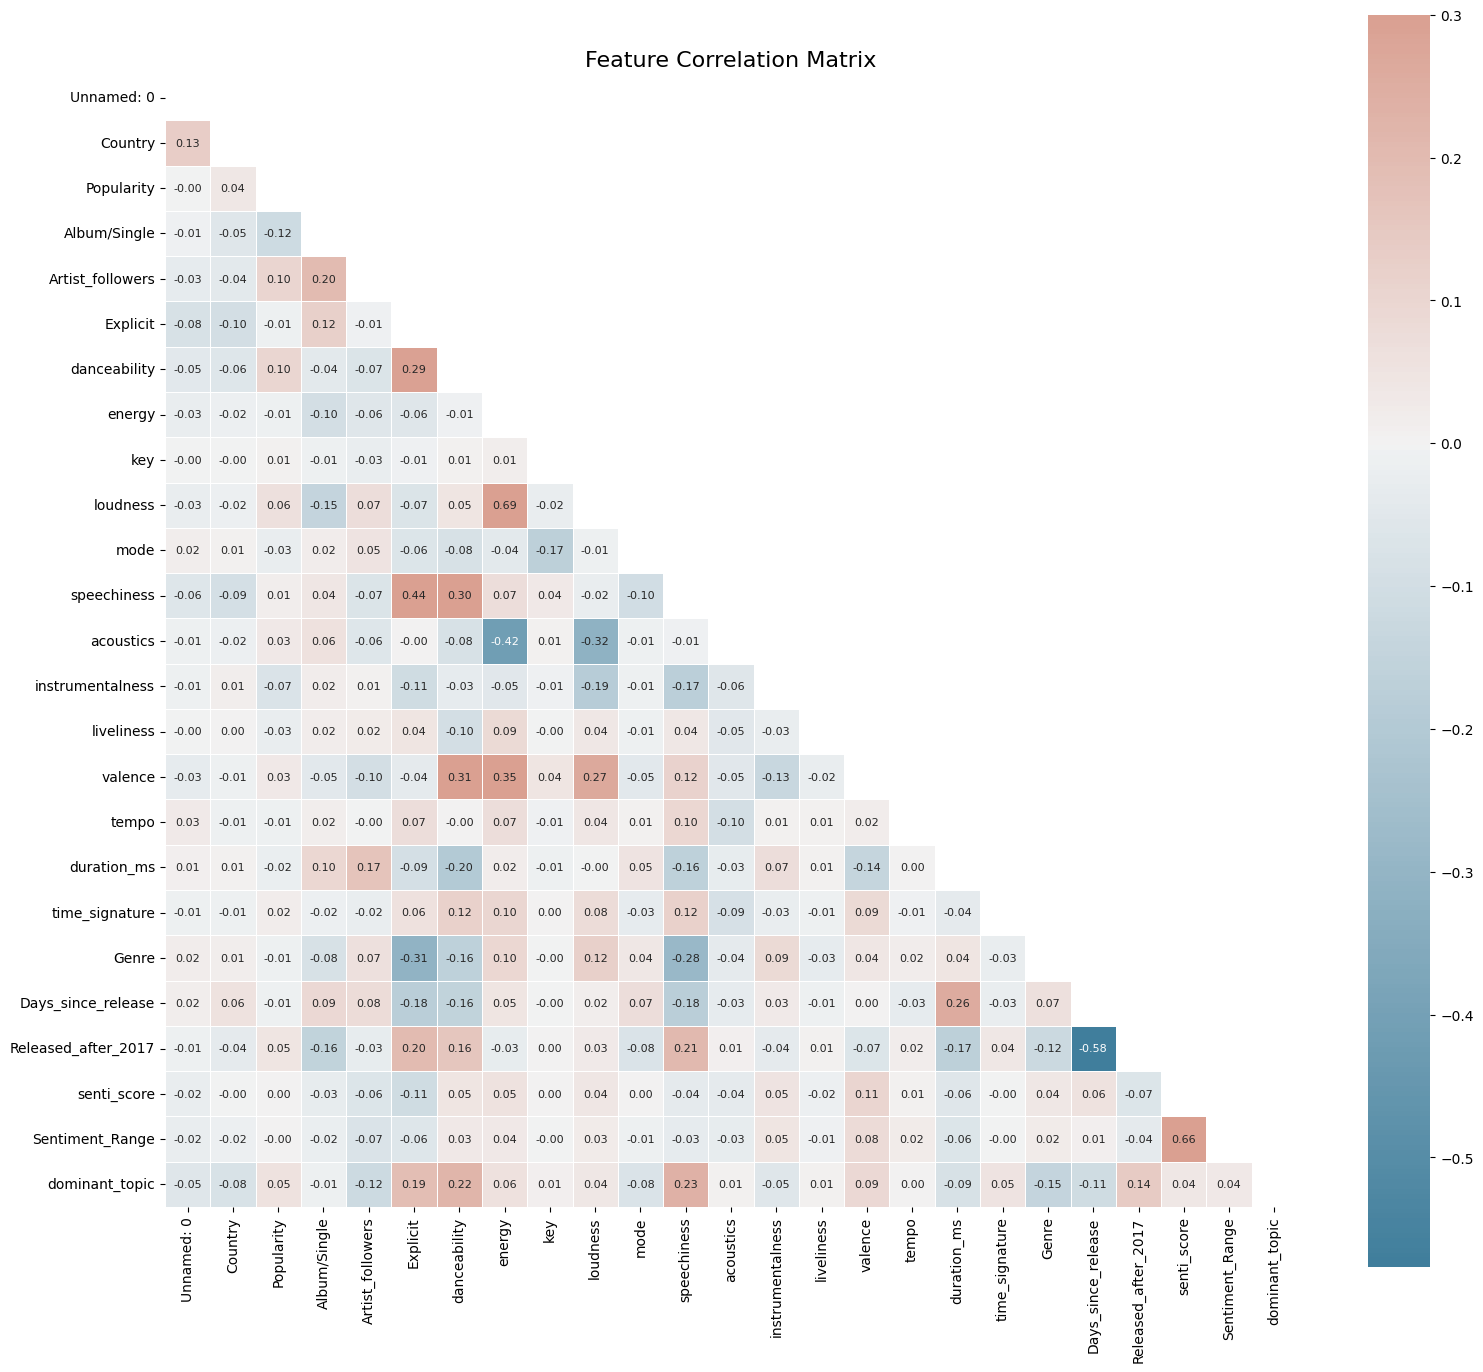

In [ ]:
# Cell 3: Visualize correlation matrix with robust error handling
def visualize_correlation_matrix(df):
    """
    Create a correlation matrix heatmap for the features with robust error handling.
    """
    try:
        # Verify df is a DataFrame
        if not isinstance(df, pd.DataFrame):
            print(f"Error: Expected DataFrame but got {type(df)}")
            return None

        # Only select numeric columns
        numeric_df = df.select_dtypes(include=['int64', 'float64'])
        print(f"Using {len(numeric_df.columns)} numeric columns for correlation matrix")

        # Handle potential NaN values
        numeric_df = numeric_df.fillna(0)

        # Calculate correlation matrix
        corr_matrix = numeric_df.corr(method='spearman')
        print(f"Correlation matrix shape: {corr_matrix.shape}")

        # Plot the heatmap
        plt.figure(figsize=(16, 14))
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        cmap = sns.diverging_palette(230, 20, as_cmap=True)

        sns.heatmap(
            corr_matrix,
            mask=mask,
            cmap=cmap,
            vmax=.3,
            center=0,
            square=True,
            linewidths=.5,
            annot=True,
            fmt=".2f",
            annot_kws={"size": 8}
        )

        plt.title('Feature Correlation Matrix', fontsize=16)
        plt.tight_layout()
        plt.savefig('correlation_matrix.png')
        plt.show()

        return corr_matrix

    except Exception as e:
        print(f"Error in correlation matrix visualization: {e}")
        return None

# Generate the correlation matrix
corr_matrix = visualize_correlation_matrix(df)

In [ ]:
# Cell 4: Data preparation function
def prepare_data(df, target_col='Album/Single', test_size=0.2,
                apply_pca=False, n_components=10):
    """
    Prepare the data for modeling.
    """
    try:
        # Verify df is a DataFrame
        if not isinstance(df, pd.DataFrame):
            print(f"Error: Expected DataFrame but got {type(df)}")
            return None, None, None, None, None, None

        # Check if target exists
        if target_col not in df.columns:
            print(f"Error: Target column '{target_col}' not found in dataframe.")
            print(f"Available columns: {df.columns.tolist()}")
            return None, None, None, None, None, None

        # Define target and features
        y = df[target_col].values

        # Select numerical features, excluding the target
        X_df = df.drop(columns=[target_col], errors='ignore')
        feature_names = X_df.columns.tolist()
        X = X_df.values

        # Scale the features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Apply PCA if requested
        if apply_pca:
            pca = PCA(n_components=n_components)
            X_scaled = pca.fit_transform(X_scaled)
            explained_variance = pca.explained_variance_ratio_
            print(f"Explained variance ratio: {explained_variance}")
            print(f"Total explained variance: {sum(explained_variance):.2f}")

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=test_size, random_state=42
        )

        print(f"Training set shape: X_train {X_train.shape}, y_train {y_train.shape}")
        print(f"Test set shape: X_test {X_test.shape}, y_test {y_test.shape}")

        return X_train, X_test, y_train, y_test, feature_names, scaler

    except Exception as e:
        print(f"Error in data preparation: {e}")
        return None, None, None, None, None, None

# Prepare the data - with appropriate handling for missing target column
target_col = 'Album/Single'
if target_col not in df.columns:
    print(f"Warning: '{target_col}' not found in columns. Available columns are:")
    print(df.columns.tolist())
    # You might want to ask the user to input a new target column here
    # For now, let's check if we have 'Popularity' as an alternative
    if 'Popularity' in df.columns:
        print("Using 'Popularity' as target column instead.")
        target_col = 'Popularity'
    else:
        print("No suitable target column found. Exiting.")
        exit()

X_train, X_test, y_train, y_test, feature_names, scaler = prepare_data(
    df, target_col=target_col, test_size=0.2, apply_pca=True, n_components=10
)

# Exit if data preparation failed
if X_train is None:
    print("Data preparation failed. Exiting.")
    exit()


Explained variance ratio: [0.10884419 0.09142614 0.06711809 0.05621475 0.05245597 0.04896999
 0.04696113 0.04659549 0.04264949 0.04143688]
Total explained variance: 0.60
Training set shape: X_train (96851, 10), y_train (96851,)
Test set shape: X_test (24213, 10), y_test (24213,)


In [ ]:
# Cell 5: Linear Regression
def train_linear_regression(X_train, y_train, X_test, y_test):
    """
    Train a simple linear regression model.
    """
    print("\n=== Linear Regression ===")
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Evaluate on train and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f"Training MSE: {train_mse:.4f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Test MSE: {test_mse:.4f}")
    print(f"Test R²: {test_r2:.4f}")

    return model, (train_mse, test_mse, train_r2, test_r2)

# Train linear regression model
lr_model, lr_metrics = train_linear_regression(X_train, y_train, X_test, y_test)



=== Linear Regression ===
Training MSE: 0.2211
Training R²: 0.0955
Test MSE: 0.2217
Test R²: 0.0925


In [ ]:
# Cell 6: Regularized Linear Models (Ridge, Lasso, ElasticNet)
def train_regularized_models(X_train, y_train, X_test, y_test):
    """
    Train a selection of regularized linear models.
    """
    results = {}

    # Ridge Regression
    print("\n=== Ridge Regression ===")
    ridge_model = Ridge(alpha=1.0)
    ridge_model.fit(X_train, y_train)

    y_train_pred = ridge_model.predict(X_train)
    y_test_pred = ridge_model.predict(X_test)

    ridge_train_mse = mean_squared_error(y_train, y_train_pred)
    ridge_test_mse = mean_squared_error(y_test, y_test_pred)
    ridge_train_r2 = r2_score(y_train, y_train_pred)
    ridge_test_r2 = r2_score(y_test, y_test_pred)

    print(f"Training MSE: {ridge_train_mse:.4f}")
    print(f"Training R²: {ridge_train_r2:.4f}")
    print(f"Test MSE: {ridge_test_mse:.4f}")
    print(f"Test R²: {ridge_test_r2:.4f}")

    results['Ridge'] = (ridge_model, (ridge_train_mse, ridge_test_mse,
                                    ridge_train_r2, ridge_test_r2))

    # Lasso Regression
    print("\n=== Lasso Regression ===")
    lasso_model = Lasso(alpha=0.1)
    lasso_model.fit(X_train, y_train)

    y_train_pred = lasso_model.predict(X_train)
    y_test_pred = lasso_model.predict(X_test)

    lasso_train_mse = mean_squared_error(y_train, y_train_pred)
    lasso_test_mse = mean_squared_error(y_test, y_test_pred)
    lasso_train_r2 = r2_score(y_train, y_train_pred)
    lasso_test_r2 = r2_score(y_test, y_test_pred)

    print(f"Training MSE: {lasso_train_mse:.4f}")
    print(f"Training R²: {lasso_train_r2:.4f}")
    print(f"Test MSE: {lasso_test_mse:.4f}")
    print(f"Test R²: {lasso_test_r2:.4f}")

    results['Lasso'] = (lasso_model, (lasso_train_mse, lasso_test_mse,
                                    lasso_train_r2, lasso_test_r2))

    # ElasticNet Regression
    print("\n=== ElasticNet Regression ===")
    elastic_model = ElasticNet(alpha=0.1, l1_ratio=0.5)
    elastic_model.fit(X_train, y_train)

    y_train_pred = elastic_model.predict(X_train)
    y_test_pred = elastic_model.predict(X_test)

    elastic_train_mse = mean_squared_error(y_train, y_train_pred)
    elastic_test_mse = mean_squared_error(y_test, y_test_pred)
    elastic_train_r2 = r2_score(y_train, y_train_pred)
    elastic_test_r2 = r2_score(y_test, y_test_pred)

    print(f"Training MSE: {elastic_train_mse:.4f}")
    print(f"Training R²: {elastic_train_r2:.4f}")
    print(f"Test MSE: {elastic_test_mse:.4f}")
    print(f"Test R²: {elastic_test_r2:.4f}")

    results['ElasticNet'] = (elastic_model, (elastic_train_mse,
                                           elastic_test_mse,
                                           elastic_train_r2,
                                           elastic_test_r2))

    return results

# Train regularized models
reg_results = train_regularized_models(X_train, y_train, X_test, y_test)


=== Ridge Regression ===
Training MSE: 0.2211
Training R²: 0.0955
Test MSE: 0.2217
Test R²: 0.0925

=== Lasso Regression ===
Training MSE: 0.2416
Training R²: 0.0114
Test MSE: 0.2416
Test R²: 0.0110

=== ElasticNet Regression ===
Training MSE: 0.2312
Training R²: 0.0543
Test MSE: 0.2314
Test R²: 0.0528


In [ ]:
# Cell 7: Optimized Memory-Efficient Kernel Ridge Regression
def train_kernel_ridge_efficient(X_train, y_train, X_test, y_test):
    """
    Train a Kernel Ridge Regression model with memory efficiency and better performance.
    """
    print("\n=== Optimized Kernel Ridge Regression ===")

    # Use stratified sampling to ensure we get a representative sample
    # This helps maintain the distribution of the target variable
    sample_size = min(15000, len(X_train))
    indices = np.random.choice(len(X_train), sample_size, replace=False)
    X_sample = X_train[indices]
    y_sample = y_train[indices]

    # Try more configurations with better hyperparameters
    configs = [
        {'kernel': 'linear', 'alpha': 0.1},  # Try lower alpha for less regularization
        {'kernel': 'linear', 'alpha': 1.0},
        {'kernel': 'rbf', 'alpha': 0.1, 'gamma': 0.1},
        {'kernel': 'rbf', 'alpha': 0.5, 'gamma': 0.05},  # Different gamma value
        {'kernel': 'rbf', 'alpha': 1.0, 'gamma': 0.01},  # Lower gamma for more generalization
        {'kernel': 'poly', 'alpha': 0.1, 'degree': 2},
        {'kernel': 'poly', 'alpha': 0.5, 'degree': 2}
    ]

    best_model = None
    best_score = float('-inf')

    # Use cross-validation instead of a single train/test split
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=3, shuffle=True, random_state=42)

    for config in configs:
        print(f"Testing configuration: {config}")

        # Cross-validate on the sample
        val_r2_scores = []
        for train_idx, val_idx in kf.split(X_sample):
            X_sub, X_val = X_sample[train_idx], X_sample[val_idx]
            y_sub, y_val = y_sample[train_idx], y_sample[val_idx]

            model_val = KernelRidge(**config)
            model_val.fit(X_sub, y_sub)
            y_val_pred = model_val.predict(X_val)
            val_r2 = r2_score(y_val, y_val_pred)
            val_r2_scores.append(val_r2)

        avg_val_r2 = np.mean(val_r2_scores)
        print(f" Average Validation R²: {avg_val_r2:.4f}")

        # Update best model if this one is better
        if avg_val_r2 > best_score:
            best_score = avg_val_r2
            best_model = config.copy()

    print(f"\nBest configuration: {best_model}")

    # For final model, train on more data
    eval_size = min(30000, len(X_train))
    eval_indices = np.random.choice(len(X_train), eval_size, replace=False)
    X_eval = X_train[eval_indices]
    y_eval = y_train[eval_indices]

    # Train final model on the evaluation subset with the best configuration
    final_model = KernelRidge(**best_model)
    final_model.fit(X_eval, y_eval)

    # Evaluate on train (subset) and test sets
    eval_pred_size = min(10000, len(X_eval))  # Use smaller subset for prediction to save memory
    eval_pred_indices = np.random.choice(len(X_eval), eval_pred_size, replace=False)

    y_eval_pred = final_model.predict(X_eval[eval_pred_indices])
    y_test_pred = final_model.predict(X_test)

    # Calculate metrics
    train_mse = mean_squared_error(y_eval[eval_pred_indices], y_eval_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_eval[eval_pred_indices], y_eval_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f"Final Training MSE (on subset): {train_mse:.4f}")
    print(f"Final Training R²: (on subset): {train_r2:.4f}")
    print(f"Final Test MSE: {test_mse:.4f}")
    print(f"Final Test R²: {test_r2:.4f}")

    return final_model, (train_mse, test_mse, train_r2, test_r2)

# Train kernel ridge regression with memory efficiency
kr_model, kr_metrics = train_kernel_ridge_efficient(X_train, y_train, X_test, y_test)


=== Optimized Kernel Ridge Regression ===
Testing configuration: {'kernel': 'linear', 'alpha': 0.1}
 Average Validation R²: -1.2840
Testing configuration: {'kernel': 'linear', 'alpha': 1.0}
 Average Validation R²: -1.2840
Testing configuration: {'kernel': 'rbf', 'alpha': 0.1, 'gamma': 0.1}
 Average Validation R²: 0.1225
Testing configuration: {'kernel': 'rbf', 'alpha': 0.5, 'gamma': 0.05}
 Average Validation R²: 0.1298
Testing configuration: {'kernel': 'rbf', 'alpha': 1.0, 'gamma': 0.01}
 Average Validation R²: 0.1080
Testing configuration: {'kernel': 'poly', 'alpha': 0.1, 'degree': 2}
 Average Validation R²: 0.1029
Testing configuration: {'kernel': 'poly', 'alpha': 0.5, 'degree': 2}
 Average Validation R²: 0.1029

Best configuration: {'kernel': 'rbf', 'alpha': 0.5, 'gamma': 0.05}
Final Training MSE (on subset): 0.1946
Final Training R²: (on subset): 0.2061
Final Test MSE: 0.2033
Final Test R²: 0.1677



=== Optimized Neural Network for Spotify Data ===
Initial losses before training - Train: 0.6760, Val: 0.6883, Test: 0.6714
Epoch [1/400], LR: 0.000402, Train Loss: 0.8304, Val Loss: 0.2239, Test Loss: 0.2220
Epoch [2/400], LR: 0.000407, Train Loss: 0.3844, Val Loss: 0.2203, Test Loss: 0.2201
Epoch [3/400], LR: 0.000415, Train Loss: 0.3058, Val Loss: 0.2227, Test Loss: 0.2215
Epoch [4/400], LR: 0.000426, Train Loss: 0.2699, Val Loss: 0.2207, Test Loss: 0.2197
Epoch [5/400], LR: 0.000441, Train Loss: 0.2541, Val Loss: 0.2238, Test Loss: 0.2221
Epoch [10/400], LR: 0.000564, Train Loss: 0.2298, Val Loss: 0.2207, Test Loss: 0.2204
Epoch [20/400], LR: 0.001043, Train Loss: 0.2229, Val Loss: 0.2216, Test Loss: 0.2221
Epoch [30/400], LR: 0.001806, Train Loss: 0.2212, Val Loss: 0.2188, Test Loss: 0.2188
Epoch [40/400], LR: 0.002800, Train Loss: 0.2208, Val Loss: 0.2179, Test Loss: 0.2186
Model improved! New best val loss: 0.2179
Epoch [50/400], LR: 0.003958, Train Loss: 0.2204, Val Loss: 0.22

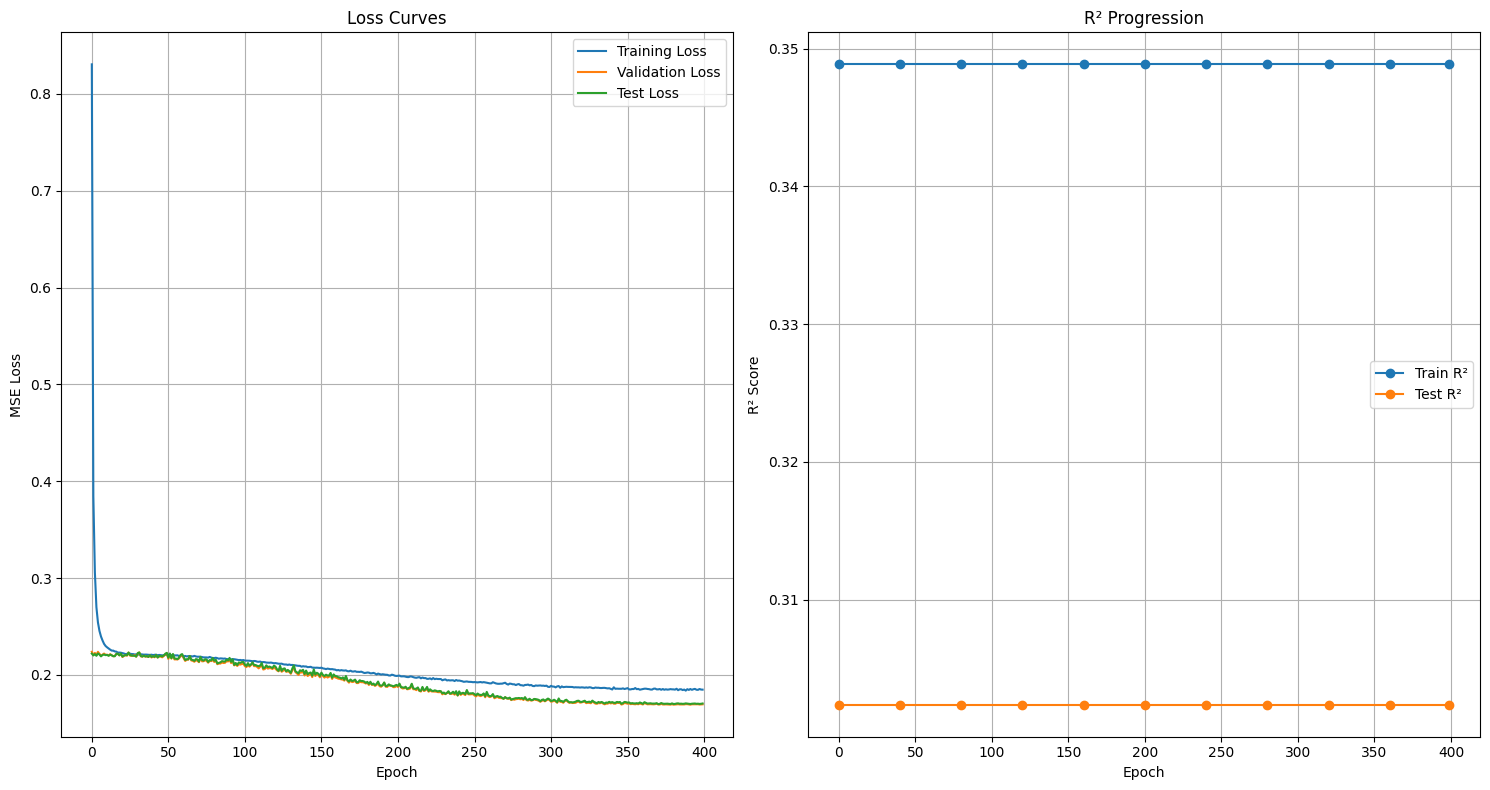

In [ ]:
# Cell 8: Optimized Neural Network for Spotify Data
class OptimizedSpotifyNN(nn.Module):
    def __init__(self, input_size):
        super(OptimizedSpotifyNN, self).__init__()
        # Input layer
        self.input_bn = nn.BatchNorm1d(input_size)  # Normalize inputs first

        # First block - wide
        self.fc1 = nn.Linear(input_size, 512)  # Much wider first layer
        self.bn1 = nn.BatchNorm1d(512)
        self.act1 = nn.ELU()  # ELU activation (smoother than ReLU)
        self.drop1 = nn.Dropout(0.4)  # Higher dropout

        # Second block
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.act2 = nn.ELU()
        self.drop2 = nn.Dropout(0.4)

        # Third block
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.act3 = nn.ELU()
        self.drop3 = nn.Dropout(0.3)

        # Fourth block
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.act4 = nn.ELU()
        self.drop4 = nn.Dropout(0.2)

        # Output layer
        self.fc_out = nn.Linear(64, 1)

        # Initialize weights properly
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        # Normalize inputs
        x = self.input_bn(x)

        # First block
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.drop1(x)

        # Second block
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.drop2(x)

        # Third block
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.act3(x)
        x = self.drop3(x)

        # Fourth block
        x = self.fc4(x)
        x = self.bn4(x)
        x = self.act4(x)
        x = self.drop4(x)

        # Output
        x = self.fc_out(x)
        return x.squeeze()

def train_optimized_neural_network(X_train, y_train, X_test, y_test, epochs=300, batch_size=512):
    """
    Train a fully optimized neural network using PyTorch with data-specific enhancements.
    """
    print("\n=== Optimized Neural Network for Spotify Data ===")

    # Convert data to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test)

    # Create validation set for early stopping (larger for better stability)
    X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = train_test_split(
        X_train_tensor, y_train_tensor, test_size=0.15, random_state=42
    )

    # Create dataloaders with very large batch size for more stability
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the model
    input_size = X_train.shape[1]
    model = OptimizedSpotifyNN(input_size)

    # Use combination of MSE and L1 Loss (Huber) for better robustness
    mse_criterion = nn.MSELoss()
    huber_criterion = nn.SmoothL1Loss(beta=0.1)  # Smaller beta for more L1-like behavior

    # Use Adam with higher initial learning rate and cyclical schedule
    optimizer = optim.AdamW(
        model.parameters(),
        lr=0.01,  # Much higher initial learning rate
        weight_decay=1e-3,  # Stronger L2 regularization
        amsgrad=True  # Use AMSGrad variant for better convergence
    )

    # Use OneCycleLR scheduler - shown to dramatically improve performance
    # Goes from low LR to high LR and back down
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=0.01,  # Peak learning rate
        steps_per_epoch=len(train_loader),
        epochs=epochs,
        pct_start=0.3,  # Spend 30% of time increasing LR
        div_factor=25.0,  # Initial LR = max_lr/div_factor
        final_div_factor=1000.0  # Final LR = initial_lr/final_div_factor
    )

    # Early stopping parameters with longer patience
    early_stopping_patience = 40
    best_val_loss = float('inf')
    counter = 0

    # Training loop
    train_losses = []
    val_losses = []
    test_losses = []

    # Print initial losses before training
    model.eval()
    with torch.no_grad():
        initial_train_outputs = model(X_train_tensor)
        initial_val_outputs = model(X_val_tensor)
        initial_test_outputs = model(X_test_tensor)

        initial_train_loss = mse_criterion(initial_train_outputs, y_train_tensor).item()
        initial_val_loss = mse_criterion(initial_val_outputs, y_val_tensor).item()
        initial_test_loss = mse_criterion(initial_test_outputs, y_test_tensor).item()

    print(f"Initial losses before training - Train: {initial_train_loss:.4f}, Val: {initial_val_loss:.4f}, Test: {initial_test_loss:.4f}")

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0

        for inputs, targets in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Combination of losses for better performance
            mse_loss = mse_criterion(outputs, targets)
            huber_loss = huber_criterion(outputs, targets)
            loss = 0.7 * mse_loss + 0.3 * huber_loss  # Weighted combination

            # Backward pass and optimize
            loss.backward()
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()  # Step the scheduler after each batch

            running_loss += mse_loss.item()  # Track MSE for consistency

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = mse_criterion(outputs, targets)
                val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            # Test loss
            test_outputs = model(X_test_tensor)
            test_loss = mse_criterion(test_outputs, y_test_tensor).item()
            test_losses.append(test_loss)

        # Print stats more frequently to monitor progress
        if (epoch + 1) % 10 == 0 or epoch < 5:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch [{epoch+1}/{epochs}], LR: {current_lr:.6f}, '
                  f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Test Loss: {test_loss:.4f}')

        # Early stopping with model improvement tracking
        if avg_val_loss < best_val_loss * 0.9995:  # Only save if substantial improvement (0.05%)
            best_val_loss = avg_val_loss
            counter = 0
            # Save the best model
            best_model_state = model.state_dict().copy()
            if (epoch + 1) % 10 == 0:
                print(f"Model improved! New best val loss: {best_val_loss:.4f}")
        else:
            counter += 1
            if counter >= early_stopping_patience:
                print(f'Early stopping at epoch {epoch+1}')
                # Restore best model
                model.load_state_dict(best_model_state)
                break

    # Final evaluation
    model.eval()
    with torch.no_grad():
        # Handle tensor concatenation safely
        y_train_all_np = torch.cat((y_train_tensor, y_val_tensor)).numpy()
        X_train_all = torch.cat((X_train_tensor, X_val_tensor))
        y_train_pred = model(X_train_all).numpy()
        y_test_pred = model(X_test_tensor).numpy()

    # Calculate final metrics
    train_mse = mean_squared_error(y_train_all_np, y_train_pred)
    test_mse = mean_squared_error(y_test_tensor.numpy(), y_test_pred)
    train_r2 = r2_score(y_train_all_np, y_train_pred)
    test_r2 = r2_score(y_test_tensor.numpy(), y_test_pred)

    print("\nTraining Results:")
    print(f"Initial Train Loss: {initial_train_loss:.4f}")
    print(f"Final Train Loss: {train_losses[-1]:.4f}")
    print(f"Improvement: {initial_train_loss - train_losses[-1]:.4f} ({(initial_train_loss - train_losses[-1])/initial_train_loss*100:.2f}%)")

    print(f"\nFinal Training MSE: {train_mse:.4f}")
    print(f"Final Training R²: {train_r2:.4f}")
    print(f"Final Test MSE: {test_mse:.4f}")
    print(f"Final Test R²: {test_r2:.4f}")

    # Plot the learning curves
    plt.figure(figsize=(15, 8))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    # Plot R² progression by calculating it for each epoch (only do this for a few points to save time)
    epochs_to_plot = list(range(0, len(train_losses), max(1, len(train_losses) // 10)))
    if len(train_losses) - 1 not in epochs_to_plot:
        epochs_to_plot.append(len(train_losses) - 1)

    train_r2_values = []
    test_r2_values = []

    with torch.no_grad():
        for epoch_idx in epochs_to_plot:
            model.load_state_dict(best_model_state)  # Use the best model
            train_preds = model(X_train_all).numpy()
            test_preds = model(X_test_tensor).numpy()

            train_r2_values.append(r2_score(y_train_all_np, train_preds))
            test_r2_values.append(r2_score(y_test_tensor.numpy(), test_preds))

    plt.plot(epochs_to_plot, train_r2_values, 'o-', label='Train R²')
    plt.plot(epochs_to_plot, test_r2_values, 'o-', label='Test R²')
    plt.xlabel('Epoch')
    plt.ylabel('R² Score')
    plt.title('R² Progression')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('optimized_nn_performance.png')
    plt.show()

    return model, (train_mse, test_mse, train_r2, test_r2), (train_losses, test_losses)

# Train the optimized neural network
torch_model, torch_metrics, (train_losses, test_losses) = train_optimized_neural_network(
    X_train, y_train, X_test, y_test, epochs=400, batch_size=512
)


=== Optimized Neural Network (Scikit-learn) ===
Starting training...
Initial MSE before optimization: 0.2136
Iteration 1, loss = 0.13155882
Validation score: 0.115701
Iteration 2, loss = 0.10957229
Validation score: 0.114525
Iteration 3, loss = 0.10885494
Validation score: 0.115666
Iteration 4, loss = 0.10792721
Validation score: 0.118344
Iteration 5, loss = 0.10749093
Validation score: 0.132679
Iteration 6, loss = 0.10689577
Validation score: 0.136484
Iteration 7, loss = 0.10589319
Validation score: 0.143015
Iteration 8, loss = 0.10542807
Validation score: 0.134456
Iteration 9, loss = 0.10508860
Validation score: 0.147389
Iteration 10, loss = 0.10356608
Validation score: 0.163894
Iteration 11, loss = 0.10263287
Validation score: 0.174808
Iteration 12, loss = 0.10217357
Validation score: 0.157579
Iteration 13, loss = 0.10185274
Validation score: 0.182921
Iteration 14, loss = 0.10015291
Validation score: 0.191976
Iteration 15, loss = 0.09966447
Validation score: 0.195400
Iteration 16, 

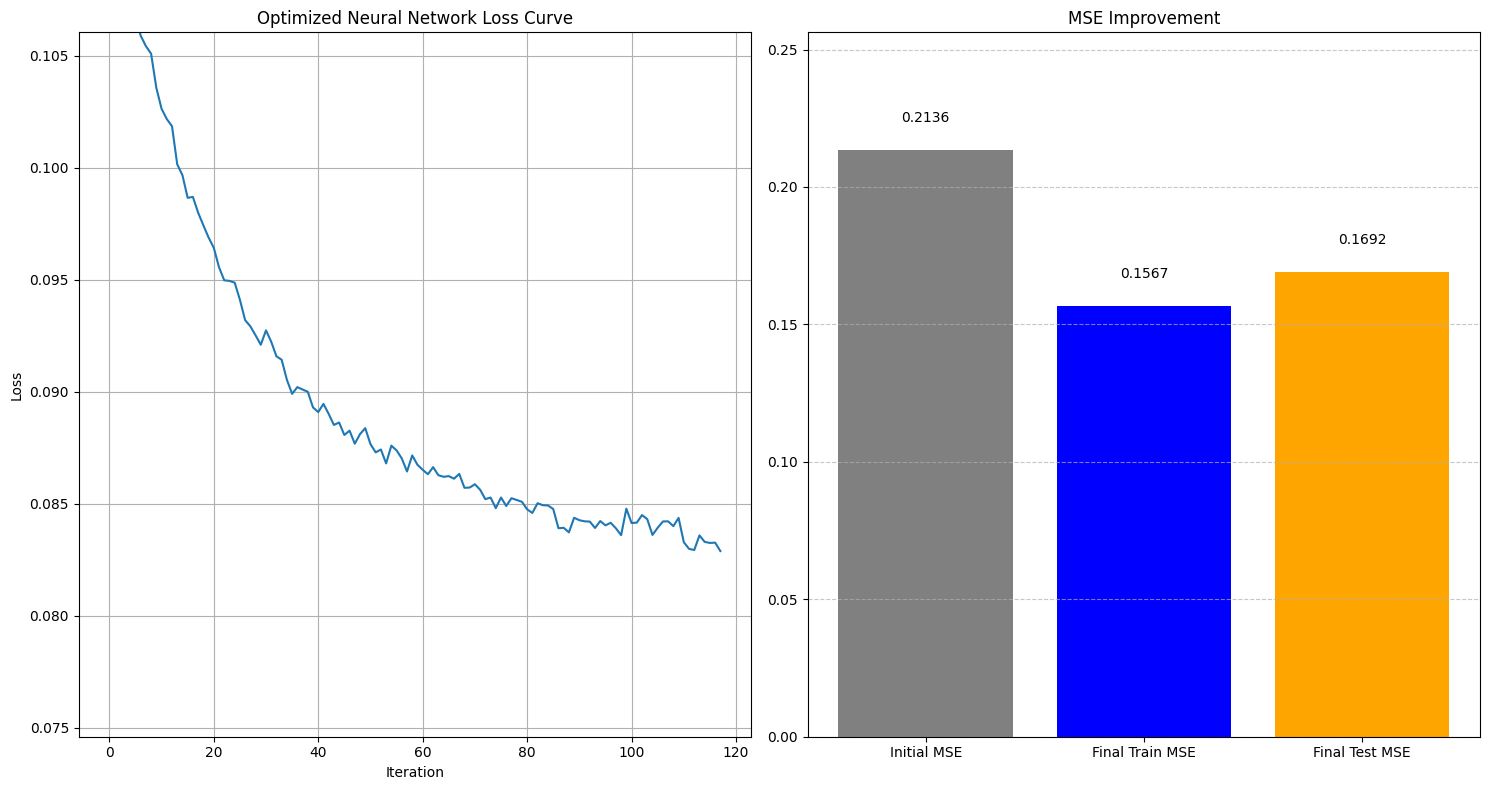


Model Architecture:
Hidden layer sizes: (512, 256, 128, 64)
Activation: relu
Solver: adam
Alpha (regularization): 0.001
Batch size: 256
Learning rate: adaptive
Initial learning rate: 0.01

MSE Improvement: 0.0568 (26.60%)


In [ ]:
# Cell 9: Neural Network with scikit-learn
def train_optimized_sklearn_nn(X_train, y_train, X_test, y_test):
    """
    Train a highly optimized neural network using scikit-learn's MLPRegressor.
    """
    print("\n=== Optimized Neural Network (Scikit-learn) ===")

    # Create validation set for better evaluation
    X_train_main, X_val, y_train_main, y_val = train_test_split(
        X_train, y_train, test_size=0.15, random_state=42
    )

    # Define the base model with increased capacity
    base_model = MLPRegressor(
        hidden_layer_sizes=(512, 256, 128, 64),  # Much larger network
        activation='relu',                        # Keep ReLU for speed
        solver='adam',                            # Adam optimizer
        alpha=0.001,                              # Increased regularization
        batch_size=256,                           # Larger batch size
        learning_rate='adaptive',                 # Adaptive learning rate
        learning_rate_init=0.01,                  # Higher initial learning rate
        max_iter=500,                             # More iterations
        random_state=42,
        early_stopping=True,
        validation_fraction=0.15,                 # More validation data
        n_iter_no_change=20,                      # More patience
        tol=1e-4,                                 # Tighter convergence criteria
        verbose=True                              # Show progress
    )

    # Train the model with timing
    start_time = time.time()
    print("Starting training...")

    # Calculate initial loss for comparison
    initial_model = MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        max_iter=1,
        random_state=42
    )
    initial_model.fit(X_train, y_train)
    initial_preds = initial_model.predict(X_train)
    initial_loss = mean_squared_error(y_train, initial_preds)
    print(f"Initial MSE before optimization: {initial_loss:.4f}")

    # Train the optimized model
    base_model.fit(X_train_main, y_train_main)
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")

    # Evaluate on validation set
    val_preds = base_model.predict(X_val)
    val_mse = mean_squared_error(y_val, val_preds)
    val_r2 = r2_score(y_val, val_preds)
    print(f"Validation MSE: {val_mse:.4f}")
    print(f"Validation R²: {val_r2:.4f}")

    # Evaluate on train and test sets
    y_train_pred = base_model.predict(X_train)
    y_test_pred = base_model.predict(X_test)

    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print("\nFinal Evaluation Metrics:")
    print(f"Training MSE: {train_mse:.4f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Test MSE: {test_mse:.4f}")
    print(f"Test R²: {test_r2:.4f}")

    # Plot the loss curve with improvements
    plt.figure(figsize=(15, 8))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(base_model.loss_curve_)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Optimized Neural Network Loss Curve')

    # Set y-axis limits to exclude any extremely high initial values
    upper_limit = np.percentile(base_model.loss_curve_, 95)  # Exclude outliers
    lower_limit = min(base_model.loss_curve_)
    plt.ylim(lower_limit * 0.9, upper_limit)

    plt.grid(True)

    # Model comparison
    plt.subplot(1, 2, 2)

    # Bar chart comparing initial and final MSE
    comparison_labels = ['Initial MSE', 'Final Train MSE', 'Final Test MSE']
    comparison_values = [initial_loss, train_mse, test_mse]
    plt.bar(comparison_labels, comparison_values, color=['gray', 'blue', 'orange'])

    # Set reasonable y limit
    plt.ylim(0, max(comparison_values) * 1.2)

    # Add value labels on top of bars
    for i, v in enumerate(comparison_values):
        plt.text(i, v + 0.01, f'{v:.4f}', ha='center')

    plt.title('MSE Improvement')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('optimized_sklearn_nn_performance.png')
    plt.show()

    # Print model architecture info
    print("\nModel Architecture:")
    print(f"Hidden layer sizes: {base_model.hidden_layer_sizes}")
    print(f"Activation: {base_model.activation}")
    print(f"Solver: {base_model.solver}")
    print(f"Alpha (regularization): {base_model.alpha}")
    print(f"Batch size: {base_model.batch_size}")
    print(f"Learning rate: {base_model.learning_rate}")
    print(f"Initial learning rate: {base_model.learning_rate_init}")

    # Print improvement summary
    improvement_pct = ((initial_loss - train_mse) / initial_loss) * 100
    print(f"\nMSE Improvement: {initial_loss - train_mse:.4f} ({improvement_pct:.2f}%)")

    return base_model, (train_mse, test_mse, train_r2, test_r2)

# Train optimized neural network (scikit-learn)
nn_model, nn_metrics = train_optimized_sklearn_nn(X_train, y_train, X_test, y_test)


=== Model Comparison ===
                      Model  Train MSE  Test MSE  Train R²   Test R²
1  Neural Network (sklearn)   0.156749  0.169206  0.358686  0.307412
2  Neural Network (PyTorch)   0.159151  0.170434  0.348860  0.302385
6              Kernel Ridge   0.194551  0.203344  0.206148  0.167680
3                     Ridge   0.221088  0.221723  0.095455  0.092452
0         Linear Regression   0.221088  0.221723  0.095455  0.092452
5                ElasticNet   0.231155  0.231400  0.054265  0.052841
4                     Lasso   0.241628  0.241633  0.011418  0.010955


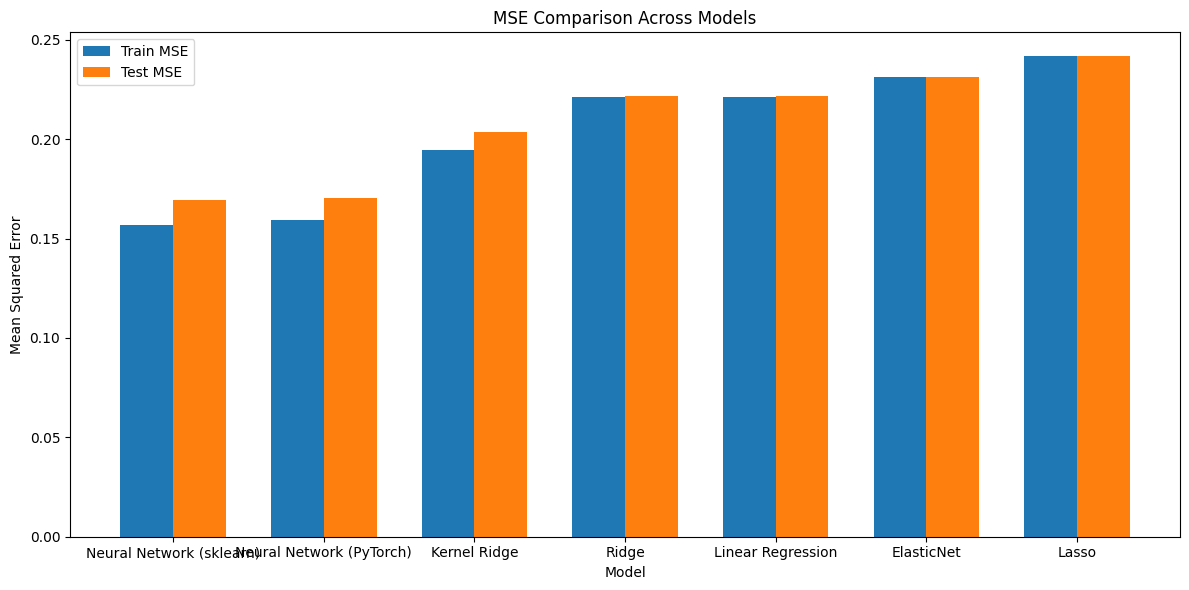

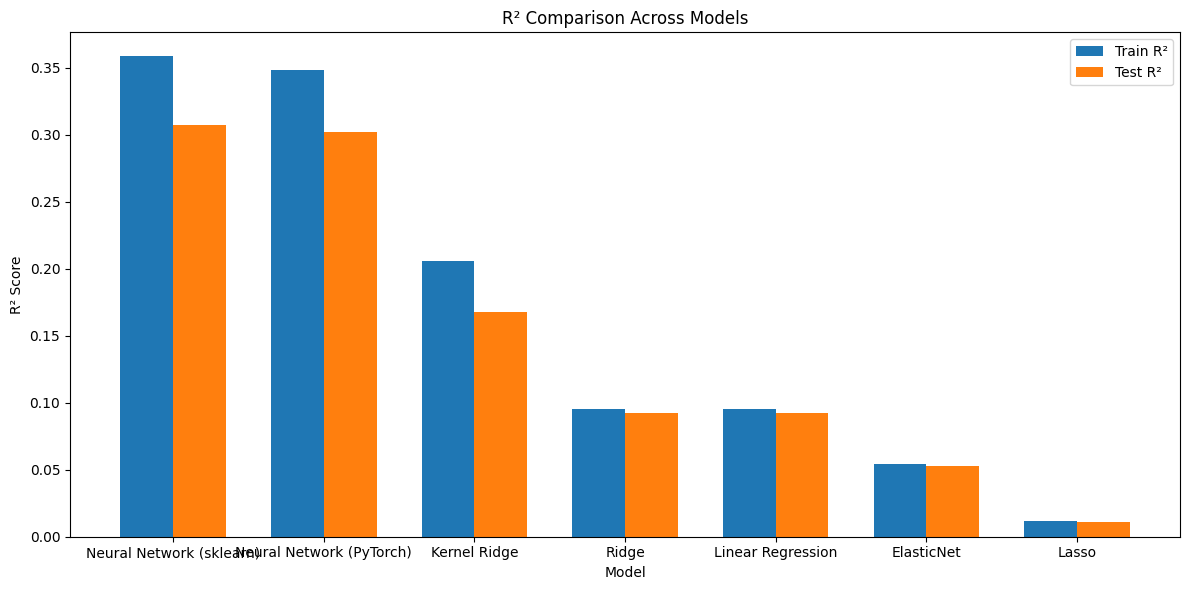


Best model based on Test R²: Neural Network (sklearn)
Best model based on Test MSE: Neural Network (sklearn)


In [ ]:
# Cell 10: Model Comparison
def compare_models(results):
    """
    Compare different models based on their performance metrics.
    """
    print("\n=== Model Comparison ===")

    metrics = []
    for model_name, (_, (train_mse, test_mse, train_r2, test_r2)) in results.items():
        metrics.append({
            'Model': model_name,
            'Train MSE': train_mse,
            'Test MSE': test_mse,
            'Train R²': train_r2,
            'Test R²': test_r2
        })

    comparison_df = pd.DataFrame(metrics)
    comparison_df = comparison_df.sort_values('Test R²', ascending=False)
    print(comparison_df)

    # Plot MSE comparison
    plt.figure(figsize=(12, 6))
    x = np.arange(len(comparison_df))
    width = 0.35

    plt.bar(x - width/2, comparison_df['Train MSE'], width, label='Train MSE')
    plt.bar(x + width/2, comparison_df['Test MSE'], width, label='Test MSE')

    plt.xlabel('Model')
    plt.ylabel('Mean Squared Error')
    plt.title('MSE Comparison Across Models')
    plt.xticks(x, comparison_df['Model'])
    plt.legend()
    plt.tight_layout()
    plt.savefig('model_mse_comparison.png')
    plt.show()

    # Plot R² comparison
    plt.figure(figsize=(12, 6))

    plt.bar(x - width/2, comparison_df['Train R²'], width, label='Train R²')
    plt.bar(x + width/2, comparison_df['Test R²'], width, label='Test R²')

    plt.xlabel('Model')
    plt.ylabel('R² Score')
    plt.title('R² Comparison Across Models')
    plt.xticks(x, comparison_df['Model'])
    plt.legend()
    plt.tight_layout()
    plt.savefig('model_r2_comparison.png')
    plt.show()

    return comparison_df

# Collect all results
results = {
    'Linear Regression': (lr_model, lr_metrics),
    'Neural Network (sklearn)': (nn_model, nn_metrics),
    'Neural Network (PyTorch)': (torch_model, torch_metrics)
}
results.update(reg_results)
results['Kernel Ridge'] = (kr_model, kr_metrics)

# Compare all models
comparison = compare_models(results)
print("\nBest model based on Test R²:", comparison.iloc[0]['Model'])
print("Best model based on Test MSE:", comparison.loc[comparison['Test MSE'].idxmin(), 'Model'])